## import and data

In [3]:
!gdown 17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq

Downloading...
From: https://drive.google.com/uc?id=17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq
To: /content/state_dicts.zip
100% 979M/979M [00:07<00:00, 126MB/s]


In [4]:
!unzip state_dicts.zip

Archive:  state_dicts.zip
   creating: state_dicts/
  inflating: state_dicts/googlenet.pt  
  inflating: state_dicts/vgg11_bn.pt  
  inflating: state_dicts/vgg13_bn.pt  
  inflating: state_dicts/resnet18.pt  
  inflating: state_dicts/vgg19_bn.pt  
  inflating: state_dicts/vgg16_bn.pt  
  inflating: state_dicts/mobilenet_v2.pt  
  inflating: state_dicts/inception_v3.pt  
  inflating: state_dicts/densenet121.pt  
  inflating: state_dicts/resnet34.pt  
  inflating: state_dicts/densenet161.pt  
  inflating: state_dicts/densenet169.pt  
  inflating: state_dicts/resnet50.pt  


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [8]:
train_transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))])
batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## base model: ResNet

In [14]:
import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

    def partial_eval(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        return x

def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        #script_dir = os.path.dirname(__file__)
        state_dict = torch.load(
            "./state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


def resnet34(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )


def resnet50(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )

In [15]:
net = resnet18(pretrained=True, progress=True, device=device)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#import pysgmcmc

In [16]:
PATH = './Res18_v3.pth'
#projection_weight_path = './LeNet_pr.pth'
torch.save(net.state_dict(), PATH)
#torch.save(net.projection, projection_weight_path)

In [18]:
PATH = './Res18_v3.pth'
#projection_weight_path = './LeNet_pr.pth'
net = resnet18(pretrained=True, progress=True, device=device).to(device)
net.load_state_dict(torch.load(PATH))
#net.projection = torch.load(projection_weight_path)

<All keys matched successfully>

In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.9151


In [79]:

from google.colab import drive
drive.mount('/content/drive')
!cp ./Res18_v3.pth /content/drive/MyDrive/Res18_v3.pth


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## NN decryption 3 party (flexible)


In [21]:
x_t = next(iter(testloader))
x_t = x_t[0].to(device)
r = net.partial_eval(x_t)
print(r.shape)

torch.Size([256, 64, 16, 16])


In [22]:
print(x_t.shape)

torch.Size([256, 3, 32, 32])


In [23]:
import copy

In [24]:
import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet_dec(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet_dec, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.enc_conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.enc_bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.enc_maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc_layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.enc_conv1(x)
        x = self.enc_bn1(x)
        x = self.relu(x)
        x = self.enc_maxpool(x)

        x = self.enc_layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

    def partial_eval(self, x):
        x = self.enc_conv1(x)
        x = self.enc_bn1(x)
        x = self.relu(x)
        x = self.enc_maxpool(x)

        x = self.enc_layer1(x)
        return x

def _resnet_dec(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet_dec(block, layers, **kwargs)
    if pretrained:
        #script_dir = os.path.dirname(__file__)
        state_dict = torch.load(
            "./state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict,strict=False)
    return model


def resnet18_dec(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet_dec(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


def resnet34_dec(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet_dec(
        "resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )


def resnet50_dec(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet_dec(
        "resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )




def construct_decrypt_net(k):
    net_decrypt = resnet18_dec()

    # freeze anything after layer1
    net_decrypt.layer2.requires_grad_(False)
    net_decrypt.layer3.requires_grad_(False)
    net_decrypt.layer4.requires_grad_(False)
    net_decrypt.fc.requires_grad_(False)

    # unfreeze last k layers
    counter = 0
    for name, param in net_decrypt.named_parameters():
        counter+=1

    #counter/=2
    c = 0

    state_dict_ = copy.deepcopy(net.state_dict())
    #print(len(state_dict_.keys()))
    #print(state_dict_.keys()[0])
    for name, param in net_decrypt.named_parameters():
        #bias and weight
        if k==0:
          pass
        elif c>=counter-int(k*1.5+1):
            param.requires_grad = True
            state_dict_.pop(name)
        c+=1
    #print(len(state_dict_.keys()))
    net_decrypt.to(device)

    #PATH = './Res18.pth'
    net_decrypt.load_state_dict(state_dict_, strict=False)
    return net_decrypt


train the top layers

In [ ]:

cosine_similarity = []
mse_ = []
test_acc= []
#cosine_similarity = cosine_similarity
#mse_ = mse_
for iteration in range(20):
    net_decrypt = construct_decrypt_net(iteration)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net_decrypt.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(30):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net_decrypt(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            '''
            if i % 1000 == 999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
                running_loss = 0.0
            '''
        #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
        running_loss = 0.0
        correct = 0
        total = 0

    print('Finished Training')

    corr = []
    MSE_loss = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    cos = torch.nn.CosineSimilarity(dim=0).to(device)
    mse_metric = nn.MSELoss().to(device)

    correct=0
    total=0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            '''
            # calculate outputs by running images through the network
            intermediate = net.partial_eval(images)
            print(intermediate.shape)
            sh = images[0,:,:,:].cpu().numpy()
            sh = sh/2+0.5
            plt.imshow(np.transpose(sh, (1,2,0)))
            plt.show()
            plt.imshow(intermediate[0,1,:,:].cpu().numpy())
            break
            outputs = net_decrypt.partial_out(intermediate)
            '''

            # calculate outputs by running images through the network
            outputs = net_decrypt(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            ori_inter = net.partial_eval(images)
            decrypt_inter = net_decrypt.partial_eval(images)
            corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))
            MSE_loss.append(mse_metric(torch.flatten(ori_inter),torch.flatten(decrypt_inter)).item())


        cosine_similarity.append((sum(corr)/len(corr)).cpu().numpy())
        print("cosine similarity for split at "+str(iteration)+": "+str(cosine_similarity[-1]))
        mse_.append((sum(MSE_loss)/len(corr)))
        test_acc.append(correct/total)
        print("test accuracy for split at "+str(iteration)+": "+str(test_acc[-1]))



Finished Training
cosine similarity for split at 0: 0.7271675
test accuracy for split at 0: 0.8427
Finished Training
cosine similarity for split at 1: 0.7489721
test accuracy for split at 1: 0.8401
Finished Training
cosine similarity for split at 2: 0.77731943
test accuracy for split at 2: 0.8404
Finished Training
cosine similarity for split at 3: 0.80481464
test accuracy for split at 3: 0.8442
Finished Training
cosine similarity for split at 4: 0.7955231
test accuracy for split at 4: 0.8476
Finished Training
cosine similarity for split at 5: 0.82179105
test accuracy for split at 5: 0.8449
Finished Training
cosine similarity for split at 6: 0.8222437
test accuracy for split at 6: 0.8341
Finished Training
cosine similarity for split at 7: 0.77624387
test accuracy for split at 7: 0.8377
Finished Training
cosine similarity for split at 8: 0.80970955
test accuracy for split at 8: 0.846
Finished Training
cosine similarity for split at 9: 0.8227098
test accuracy for split at 9: 0.8419
Finish

KeyboardInterrupt: ignored

In [ ]:
print(mse_)
print(cosine_similarity)
print(test_acc)

[1.3757064555780576, 1.2174986303804782, 1.3829171276701906, 1.4613700945156451, 1.451703663070362, 1.5190820728247159, 1.5603145802744662, 1.445120233316391, 1.5245656990014707, 1.6183720293898172, 1.5911245951637292, 1.583609141861669]
[array(0.7271675, dtype=float32), array(0.7489721, dtype=float32), array(0.77731943, dtype=float32), array(0.80481464, dtype=float32), array(0.7955231, dtype=float32), array(0.82179105, dtype=float32), array(0.8222437, dtype=float32), array(0.77624387, dtype=float32), array(0.80970955, dtype=float32), array(0.8227098, dtype=float32), array(0.81974787, dtype=float32), array(0.82414687, dtype=float32)]
[0.8427, 0.8401, 0.8404, 0.8442, 0.8476, 0.8449, 0.8341, 0.8377, 0.846, 0.8419, 0.84, 0.8411]


In [28]:
#net_decrypt = construct_decrypt_net(3)

for name, param in net_decrypt.named_parameters():
    print(name+'\t\t\t'+str(param.requires_grad))


enc_conv1.weight			True
enc_bn1.weight			True
enc_bn1.bias			True
enc_layer1.0.conv1.weight			True
enc_layer1.0.bn1.weight			True
enc_layer1.0.bn1.bias			True
enc_layer1.0.conv2.weight			True
enc_layer1.0.bn2.weight			True
enc_layer1.0.bn2.bias			True
enc_layer1.1.conv1.weight			True
enc_layer1.1.bn1.weight			True
enc_layer1.1.bn1.bias			True
enc_layer1.1.conv2.weight			True
enc_layer1.1.bn2.weight			True
enc_layer1.1.bn2.bias			True
layer2.0.conv1.weight			False
layer2.0.bn1.weight			False
layer2.0.bn1.bias			False
layer2.0.conv2.weight			False
layer2.0.bn2.weight			False
layer2.0.bn2.bias			False
layer2.0.downsample.0.weight			False
layer2.0.downsample.1.weight			False
layer2.0.downsample.1.bias			False
layer2.1.conv1.weight			False
layer2.1.bn1.weight			False
layer2.1.bn1.bias			False
layer2.1.conv2.weight			False
layer2.1.bn2.weight			False
layer2.1.bn2.bias			False
layer3.0.conv1.weight			False
layer3.0.bn1.weight			False
layer3.0.bn1.bias			False
layer3.0.conv2.weight			False
lay

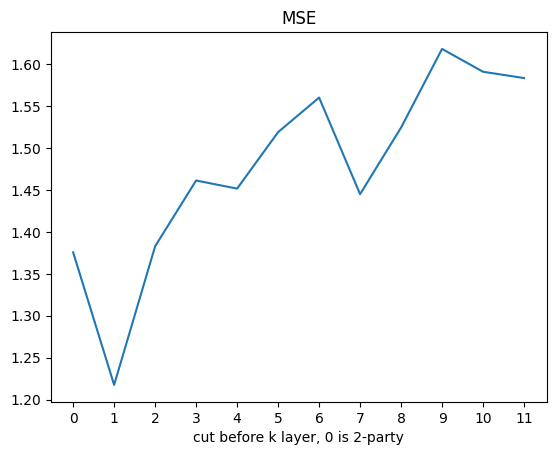

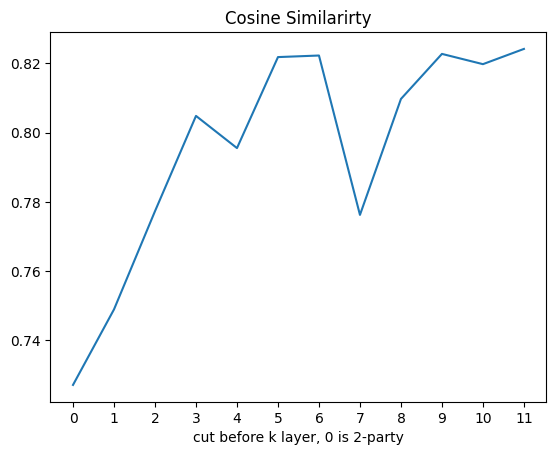

In [ ]:
x = [i for i in range(len(mse_))]
xi = [i for i in range(len(mse_))]
plt.plot(x, mse_)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title('MSE')
plt.show()
plt.plot(x, cosine_similarity)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title("Cosine Similarirty")
plt.show()

In [ ]:
# test cosine similarity for initialization
cosine_similarity = []
mse_ = []
test_acc= []
#cosine_similarity = cosine_similarity
#mse_ = mse_
for iteration in range(20):
    net_decrypt = construct_decrypt_net(iteration)

    corr = []
    MSE_loss = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    cos = torch.nn.CosineSimilarity(dim=0).to(device)
    mse_metric = nn.MSELoss().to(device)

    correct=0
    total=0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            '''
            # calculate outputs by running images through the network
            intermediate = net.partial_eval(images)
            print(intermediate.shape)
            sh = images[0,:,:,:].cpu().numpy()
            sh = sh/2+0.5
            plt.imshow(np.transpose(sh, (1,2,0)))
            plt.show()
            plt.imshow(intermediate[0,1,:,:].cpu().numpy())
            break
            outputs = net_decrypt.partial_out(intermediate)
            '''

            # calculate outputs by running images through the network
            outputs = net_decrypt(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            ori_inter = net.partial_eval(images)
            decrypt_inter = net_decrypt.partial_eval(images)
            corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))
            MSE_loss.append(mse_metric(torch.flatten(ori_inter),torch.flatten(decrypt_inter)).item())


        cosine_similarity.append((sum(corr)/len(corr)).cpu().numpy())
        print("cosine similarity for split at "+str(iteration)+": "+str(cosine_similarity[-1]))
        mse_.append((sum(MSE_loss)/len(corr)))
        test_acc.append(correct/total)
        print("test accuracy for split at "+str(iteration)+": "+str(test_acc[-1]))

cosine similarity for split at 0: 0.3707772
test accuracy for split at 0: 0.1688
cosine similarity for split at 1: 0.38429928
test accuracy for split at 1: 0.0805
cosine similarity for split at 2: 0.37930742
test accuracy for split at 2: 0.1165
cosine similarity for split at 3: 0.3821619
test accuracy for split at 3: 0.1151
cosine similarity for split at 4: 0.37715706
test accuracy for split at 4: 0.1016
cosine similarity for split at 5: 0.36769122
test accuracy for split at 5: 0.1036
cosine similarity for split at 6: 0.37807548
test accuracy for split at 6: 0.1003
cosine similarity for split at 7: 0.37103155
test accuracy for split at 7: 0.0651
cosine similarity for split at 8: 0.36308458
test accuracy for split at 8: 0.0995
cosine similarity for split at 9: 0.3712679
test accuracy for split at 9: 0.0775
cosine similarity for split at 10: 0.36660957
test accuracy for split at 10: 0.1036
cosine similarity for split at 11: 0.38123107
test accuracy for split at 11: 0.0996
cosine similari

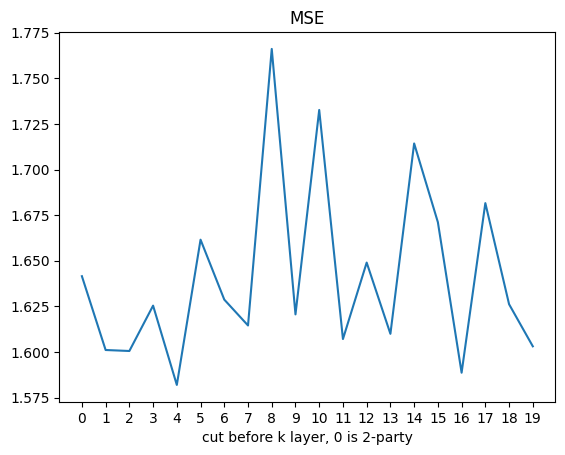

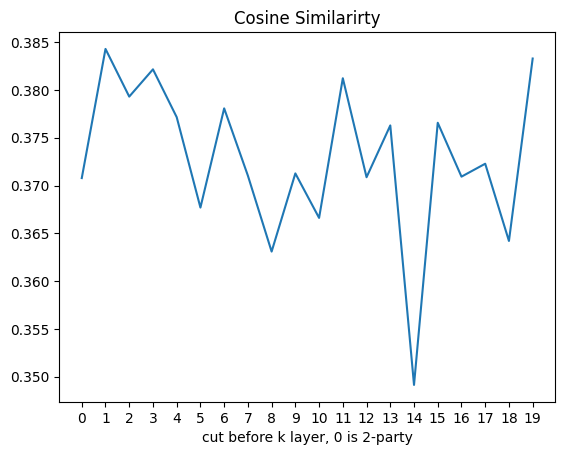

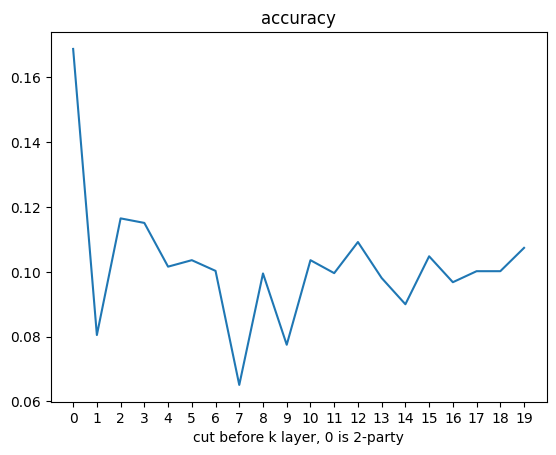

In [ ]:
#untrained initialization
x = [i for i in range(len(mse_))]
xi = [i for i in range(len(mse_))]
plt.plot(x, mse_)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title('MSE')
plt.show()
plt.plot(x, cosine_similarity)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title("Cosine Similarirty")
plt.show()
plt.plot(x, test_acc)
plt.xticks(x, xi)
plt.xlabel("cut before k layer, 0 is 2-party")
plt.title("accuracy")
plt.show()

In [60]:

#cosine_similarity = cosine_similarity
#mse_ = mse_

net_decrypt = construct_decrypt_net(0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_decrypt.parameters(), lr=0.01, momentum=0.9)
# close to original 120
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decrypt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0
    correct = 0
    total = 0

print('Finished Training')

corr = []
MSE_loss = []
# since we're not training, we don't need to calculate the gradients for our outputs
cos = torch.nn.CosineSimilarity(dim=0).to(device)
mse_metric = nn.MSELoss().to(device)

correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''

        # calculate outputs by running images through the network
        outputs = net_decrypt(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        ori_inter = net.partial_eval(images)
        decrypt_inter = net_decrypt.partial_eval(images)
        corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))
        MSE_loss.append(mse_metric(torch.flatten(ori_inter),torch.flatten(decrypt_inter)).item())





Finished Training


In [65]:
print(sum(corr)/len(corr))
print(sum(MSE_loss)/len(MSE_loss))

tensor(0.8156, device='cuda:0')
2.430614376068115


In [66]:
#PATH = './ResNet_decrypt_3.pth'
PATH = './ResNet_decrypt_v3.pth'

torch.save(net_decrypt.state_dict(), PATH)

In [67]:
PATH = './ResNet_decrypt_v3.pth'

net_decrypt.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
PATH2 = './Res18_v2.pth'
#projection_weight_path = './LeNet_pr.pth'
net = ResNet18(img_channels=3, num_classes=10).to(device)
net.load_state_dict(torch.load(PATH2))

In [68]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''
        outputs = net_decrypt(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.8999


In [33]:

#!cp ./ResNet_decrypt_3.pth /content/drive/MyDrive/ResNet_decrypt_3.pth

!cp ./ResNet_decrypt_v3.pth /content/drive/MyDrive/ResNet_decrypt_v3.pth

what we know: bad performance when using CNN to simulate 1 layer of ResNet -> unknown architecture could cause significant defifference

on the other hand, if we know the architecture, we can somewhat recover the weights and use decoder to recover the image

conclusion1 of now: there exists "SOME" encoder-decoder group that can recover the image if the server knows the training dataset

conclusion2 of now: model similarity is inverse propotional to the computation on the client side: more computation on the client side -> less similar the intermediate image is.

when server only computes layer 2 and 3, cosine similarity is 0.4, whereas when server computes layer 2-4, cosine similarity is 0.86.

As of now, decoder designed based on encoder (transpose conv) does not generate accurate decoding image.

TODO:
1. is there a p-tolerant decoder that recovers images with at least p cosine similarity?
2. try client-server split at each layer and measure the cosine similarity of intermediate latent feature -> expect to see a decay
3. is there a boundary on how good a decoder can be?


### decoder

In [69]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet_decoder(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_decoder, self).__init__()
        self.inplanes = 64

        replace_stride_with_dilation = [False, False, False]
        layers = num_blocks
        self._norm_layer = nn.BatchNorm2d
        self.dilation = 1
        self.groups = 1
        self.base_width = 64

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.enc_conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.enc_bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.enc_maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.enc_layer1 = self._make_layer(block, 64, layers[0],1)
        '''
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        '''

        self.dec_layer1=self._make_layer(block, 64, layers[0],1)
        self.upsample = nn.Upsample(scale_factor=2)
        self.dec2 = nn.BatchNorm2d(64)
        self.dec1 = nn.Conv2d(64, 3, kernel_size=3,
                               stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.enc_conv1(x)
        x = self.enc_bn1(x)
        x = self.relu(x)
        x = self.enc_maxpool(x)

        x = self.enc_layer1(x)
        '''
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
        '''
        out = self.dec_layer1(x)
        out = self.upsample(out)
        out = self.relu(out)
        #out = F.relu(self.dec1(self.dec2(x)))
        out = self.dec2(out)
        out = self.dec1(out)
        return out

    def partial_eval(self, x):
        out = self.dec_layer1(x)
        out = self.upsample(out)
        out = self.relu(out)
        #out = F.relu(self.dec1(self.dec2(x)))
        out = self.dec2(out)
        out = self.dec1(out)
        return out


def ResNet18_decoder():
    return ResNet_decoder(BasicBlock, [2, 2, 2, 2])


def ResNet34_decoder():
    return ResNet_decoder(BasicBlock, [3, 4, 6, 3])

net_decoder = ResNet18_decoder()
net_decoder.to(device)



ResNet_decoder(
  (enc_conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (enc_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (enc_maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc_layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

In [70]:
'''
PATH = './LeNet_decrypt.pth'
net_decoder.load_state_dict(torch.load(PATH), strict=False)
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)
'''

# freeze anything before decoder
net_decoder.enc_conv1.requires_grad_(False)
net_decoder.enc_bn1.requires_grad_(False)
net_decoder.enc_layer1.requires_grad_(False)


Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [71]:
for param in net_decoder.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [72]:
PATH = './ResNet_decrypt_v3.pth'
net_decoder.load_state_dict(torch.load(PATH), strict=False)

_IncompatibleKeys(missing_keys=['dec_layer1.0.conv1.weight', 'dec_layer1.0.bn1.weight', 'dec_layer1.0.bn1.bias', 'dec_layer1.0.bn1.running_mean', 'dec_layer1.0.bn1.running_var', 'dec_layer1.0.conv2.weight', 'dec_layer1.0.bn2.weight', 'dec_layer1.0.bn2.bias', 'dec_layer1.0.bn2.running_mean', 'dec_layer1.0.bn2.running_var', 'dec_layer1.1.conv1.weight', 'dec_layer1.1.bn1.weight', 'dec_layer1.1.bn1.bias', 'dec_layer1.1.bn1.running_mean', 'dec_layer1.1.bn1.running_var', 'dec_layer1.1.conv2.weight', 'dec_layer1.1.bn2.weight', 'dec_layer1.1.bn2.bias', 'dec_layer1.1.bn2.running_mean', 'dec_layer1.1.bn2.running_var', 'dec2.weight', 'dec2.bias', 'dec2.running_mean', 'dec2.running_var', 'dec1.weight'], unexpected_keys=['layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_

In [73]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)

In [74]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decoder(inputs)
        #outputs = net.partial_eval(inputs)
        #outputs = net_decoder(outputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0
print('Finished Training')

[1,   196] loss: 0.335
[2,   196] loss: 0.167
[3,   196] loss: 0.139
[4,   196] loss: 0.126
[5,   196] loss: 0.117
[6,   196] loss: 0.110
[7,   196] loss: 0.105
[8,   196] loss: 0.101
[9,   196] loss: 0.097
[10,   196] loss: 0.094
[11,   196] loss: 0.091
[12,   196] loss: 0.089
[13,   196] loss: 0.087
[14,   196] loss: 0.085
[15,   196] loss: 0.083
[16,   196] loss: 0.082
[17,   196] loss: 0.080
[18,   196] loss: 0.079
[19,   196] loss: 0.078
[20,   196] loss: 0.077
[21,   196] loss: 0.076
[22,   196] loss: 0.075
[23,   196] loss: 0.074
[24,   196] loss: 0.072
[25,   196] loss: 0.072
[26,   196] loss: 0.071
[27,   196] loss: 0.070
[28,   196] loss: 0.069
[29,   196] loss: 0.069


KeyboardInterrupt: ignored

In [75]:
img_compare = testset[0][0].cuda()

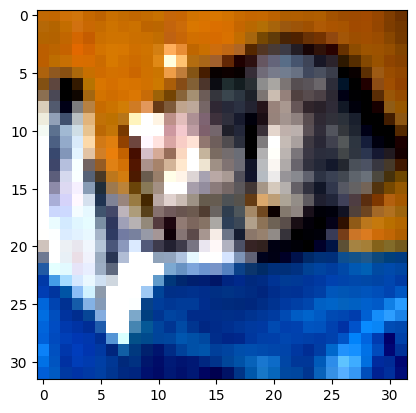

In [76]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(img_compare.detach().cpu())

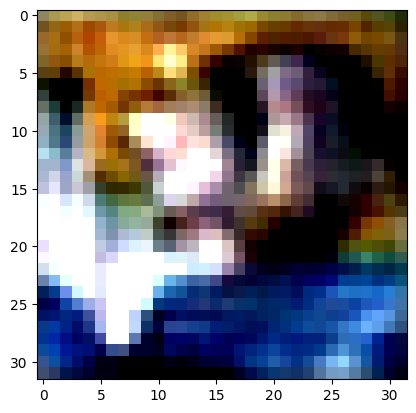

In [77]:
target = img_compare[None,:,:,:]
result = net_decoder.partial_eval((net_decrypt.partial_eval(target)))
imshow(result[0].detach().cpu())

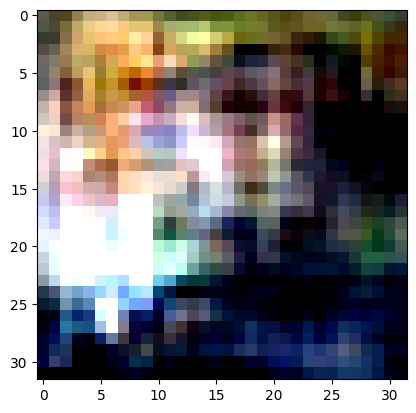

In [78]:
target = img_compare[None,:,:,:]
result = net_decoder.partial_eval((net.partial_eval(target)))
imshow(result[0].detach().cpu())

compare weights between two models

In [ ]:
weight_diff = [(x - y).abs().sum() for x, y in zip(net.state_dict().values(), net_decrypt.state_dict().values())]

In [ ]:
net.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.conv1.bias', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.conv2.bias', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.conv3.bias', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.identity_downsample.0.weight', 'layer1.0.identity_downsample.0.bias', 'layer1.0.identity_downsample.1.weight', 'layer1.0.identity_downsample.1.bias', 'layer1.0.identity_downsample.1.running_mean', 'layer1.0.identity_downsample.1.running_var', 'layer1.0.identity_downsample.1.num_batches_tracked', 'lay

In [ ]:
net_values = []
for n,_ in net.named_parameters():
  net_values.append(net.state_dict()[n])
net_decrypt_values = []
for n,_ in net_decrypt.named_parameters():
  net_decrypt_values.append(net_decrypt.state_dict()[n])

In [ ]:
diff = [net_decrypt_values[i] - net_values[i] for i in range(len(net_values))]

In [ ]:
cos = torch.nn.CosineSimilarity(dim=0).to(device)
i = 0
for n,_ in net_decrypt.named_parameters():
  output = cos(torch.flatten(net_values[i]), torch.flatten(net_decrypt_values[i]))
  print(n+'\t\t\t'+str(output.cpu().numpy()))
  i+=1

enc1.weight			0.0248543
enc1.bias			-0.040352307
enc2.weight			0.99136543
enc2.bias			0.269043
enc_layer1.0.conv1.weight			0.02394851
enc_layer1.0.conv1.bias			-0.07429153
enc_layer1.0.bn1.weight			1.0
enc_layer1.0.bn1.bias			0.0
enc_layer1.0.conv2.weight			0.0059722904
enc_layer1.0.conv2.bias			-0.056167904
enc_layer1.0.bn2.weight			0.99675333
enc_layer1.0.bn2.bias			0.31944263
enc_layer1.0.conv3.weight			-0.0016735625
enc_layer1.0.conv3.bias			0.0057369545
enc_layer1.0.bn3.weight			0.99490535
enc_layer1.0.bn3.bias			0.046297792
enc_layer1.0.identity_downsample.0.weight			-0.0018739784
enc_layer1.0.identity_downsample.0.bias			0.08620225
enc_layer1.0.identity_downsample.1.weight			0.99098605
enc_layer1.0.identity_downsample.1.bias			0.046297792
enc_layer1.1.conv1.weight			0.0049554654
enc_layer1.1.conv1.bias			0.029795337
enc_layer1.1.bn1.weight			1.0
enc_layer1.1.bn1.bias			0.0
enc_layer1.1.conv2.weight			0.002168947
enc_layer1.1.conv2.bias			-0.2096956
enc_layer1.1.bn2.weight			0.99

compare imtermediate images

In [ ]:
corr = []

# since we're not training, we don't need to calculate the gradients for our outputs
cos = torch.nn.CosineSimilarity(dim=0).to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''
        ori_inter = net.partial_eval(images)
        decrypt_inter = net_decrypt.partial_eval(images)
        corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))


print(corr[:10])

[tensor(0.4085, device='cuda:0'), tensor(0.4051, device='cuda:0'), tensor(0.4034, device='cuda:0'), tensor(0.4021, device='cuda:0'), tensor(0.4012, device='cuda:0'), tensor(0.4135, device='cuda:0'), tensor(0.3963, device='cuda:0'), tensor(0.3992, device='cuda:0'), tensor(0.4094, device='cuda:0'), tensor(0.4050, device='cuda:0')]


In [ ]:
sum(corr)/len(corr)

tensor(0.4066, device='cuda:0')

## store data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/LeNet.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_decrypt.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_pr.pth /content/drive/MyDrive/security_weight

### additional